# Agentic Router RAG with LangGraph

In this notebook, we'll build an agentic RAG system that can route queries to the appropriate data source, including web search for current information. This solves some of the limitations we saw in the basic RAG approach.

## What is Agentic Router RAG?

Router RAG adds an intelligent routing layer that:
1. **Analyzes the query** to understand the user's intent
2. **Routes to the appropriate data source** (catalog, FAQ, troubleshooting, or web search)
3. **Retrieves relevant documents** from the correct collection or searches the web
4. **Generates contextual answers** using only relevant information

## Learning Objectives

By the end of this notebook, you will:
- Understand how query routing works in RAG systems
- Connect to multiple ChromaDB collections, for different types of data
- Integrate web search for current information using Tavily
- Build a router node that classifies query intent
- Create conditional workflows in LangGraph
- Compare router RAG performance with basic RAG

## Setup and Imports

We'll need additional imports for the router functionality and structured output.

In [50]:
import os
from pathlib import Path
from typing import List, TypedDict, Literal

from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.retrievers import TavilySearchAPIRetriever
from langgraph.graph import StateGraph, END
from pydantic import BaseModel, Field
from IPython.display import Image, display

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


## Environment Setup

Check for required environment variables.

In [2]:
# Check if OpenAI API key is available
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY environment variable is required")

# Check if Tavily API key is available
tavily_api_key = os.getenv("TAVILY_API_KEY")
if not tavily_api_key:
    raise ValueError("TAVILY_API_KEY environment variable is required for web search functionality")

print("OpenAI API key found!")
print("Tavily API key found!")

OpenAI API key found!
Tavily API key found!


## Understanding Our Separate Collections

Unlike the basic RAG notebook, we now have three separate ChromaDB collections:

1. **techmart_catalog**: Product information, specifications, and descriptions
2. **techmart_faq**: Customer service questions about shipping, returns, policies
3. **techmart_troubleshooting**: Technical support guides and solutions

Each collection contains documents optimized for its specific domain.

## Connect to Separate ChromaDB Collections

We'll create three separate vector store instances, one for each collection.

In [3]:
# Initialize embeddings model (same as used during ingestion)
embeddings = OpenAIEmbeddings(
    model=os.getenv("OPENAI_EMBEDDING_MODEL", "text-embedding-3-small"),
    api_key=openai_api_key
)

# Path to the separate ChromaDB collections
chroma_db_path = Path("..") / "vector_store" / "chroma_db_separate"

# Connect to each collection
catalog_store = Chroma(
    collection_name="techmart_catalog",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

faq_store = Chroma(
    collection_name="techmart_faq",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

troubleshooting_store = Chroma(
    collection_name="techmart_troubleshooting",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

print(f"Connected to separate ChromaDB collections at: {chroma_db_path}")
print(f"Catalog collection: {catalog_store._collection.count()} documents")
print(f"FAQ collection: {faq_store._collection.count()} documents")
print(f"Troubleshooting collection: {troubleshooting_store._collection.count()} documents")

Connected to separate ChromaDB collections at: ../vector_store/chroma_db_separate
Catalog collection: 325 documents
FAQ collection: 50 documents
Troubleshooting collection: 154 documents


## Test Each Collection

Let's verify each collection contains the expected type of information.

In [56]:
# Test each collection with a relevant query
test_queries = {
    "catalog": "laptop with good performance",
    "faq": "shipping times", 
    "troubleshooting": "battery drain problem"
}

stores = {
    "catalog": catalog_store,
    "faq": faq_store,
    "troubleshooting": troubleshooting_store
}

for collection_name, query in test_queries.items():
    store = stores[collection_name]
    results = store.similarity_search(query, k=2)
    
    print(f"\n{collection_name.upper()} Collection - Query: '{query}'")
    print("=" * 60)
    for i, doc in enumerate(results, 1):
        print(f"Document {i}: {doc.page_content[:150]}...")
    print("-" * 60)


CATALOG Collection - Query: 'laptop with good performance'
Document 1: product_id: SKU232 | name: ZenithBook 11 Evo | category: Laptop | price: 1299.0 | short_desc: A sleek 15-inch ultrabook with Intel Core i7, 16GB RAM, ...
Document 2: product_id: SKU050 | name: ZenithBook 15 Evo | category: Laptop | price: 1299.0 | short_desc: 15.6" ultralight laptop with Intel Core i7, 16GB RAM, sp...
------------------------------------------------------------

FAQ Collection - Query: 'shipping times'
Document 1: question: How long does standard shipping take within the continental US? | answer: Standard shipping typically arrives in 3–5 business days once your...
Document 2: question: Do you offer next‑day delivery for laptops? | answer: Yes, we offer overnight delivery on all in‑stock laptops for orders placed before 2 p....
------------------------------------------------------------

TROUBLESHOOTING Collection - Query: 'battery drain problem'
Document 1: issue_title: UltraBook Pro battery drai

## Initialize Language Models

We'll use separate OpenAI models for routing decisions and answer generation. This flexibility in an agentic RAG workflow gives us an opportunity to optimise cost and latency while making sure the performance of the overall system remains optimal.

In [22]:
# Initialize the language model for generating answers
generation_llm = ChatOpenAI(
    model=os.getenv("OPENAI_MODEL", "gpt-4.1-mini"),
    api_key=openai_api_key
)
print(f"Answer generation language model initialized: {generation_llm.model_name}")

# Initialize the language model for routing decisions
routing_llm = ChatOpenAI(
    model="gpt-4.1-mini",
    api_key=openai_api_key
)
print(f"Routing language model initialized: {routing_llm.model_name}")

Answer generation language model initialized: gpt-4.1
Routing language model initialized: gpt-4.1-mini


## Define Router Output Schema

We'll use Pydantic to define the structure of our router's output, ensuring it always returns one of our three valid collection names.

In [23]:
class RouterOutput(BaseModel):
    """Output schema for the query router."""
    chosen_collection: Literal["catalog", "faq", "troubleshooting", "web_search"] = Field(
        description="The collection to route the query to based on intent"
    )
    reasoning: str = Field(
        description="Brief explanation of why this collection was chosen"
    )

print("Router output schema defined!")

Router output schema defined!


## Create Router Prompt Template

This prompt will guide the LLM to classify queries and route them to the appropriate collection.

In [25]:
# Router prompt for query classification
router_prompt = ChatPromptTemplate.from_template(
    """You are a query router for TechMart, an electronics retailer. 
Analyze the user's query and determine which collection contains the most relevant information.

Collections available:
- **catalog**: Product information, specifications recommendations, comparisons, and technical details about laptops, desktops, monitors, and accessories
- **faq**: Customer service questions about shipping, delivery, returns, warranties, policies, and general business operations
- **troubleshooting**: Technical support guides, problem diagnosis, step-by-step solutions, and fixes for product issues that TechMart sells
- **web_search**: For questions about issues that are not covered in our internal troubleshooting database, or for getting the latest information about software, hardware, drivers, or anything that require current information from the internet

Query: {query}

Instructions:
- Choose the single most appropriate collection for this query
- If a query spans multiple domains, choose the primary intent
- Use web_search for troubleshooting issues that are likely not covered in our limited internal database
- Provide brief reasoning for your choice

Examples:
- "What laptops do you recommend?" → catalog (product recommendations)
- "How long does shipping take?" → faq (shipping policy)
- "My laptop won't turn on" → troubleshooting (common technical problem we likely have guides for)
- "Best gaming desktop under $2000" → catalog (product search with specs)
- "Can I return a monitor?" → faq (return policy)
- "Headphones keep disconnecting" → troubleshooting (common connectivity issue)
- "Windows 11 blue screen error 0x0000007E" → web_search (specific system error requiring current information)
- "How to fix Chrome crashes on latest macOS" → web_search (software issue needing current solutions)
- "Latest NVIDIA driver causing display issues" → web_search (current driver problem not in our database)
- "WiFi adapter not working after Windows update" → web_search (current OS compatibility issue)
"""
)

# Create router chain with structured output
router_chain = router_prompt | routing_llm.with_structured_output(RouterOutput)

print("Router prompt and chain created!")

Router prompt and chain created!


## Test the Router

Let's test our router with different types of queries to see how it classifies them.

In [27]:
# Test queries for each collection type including web search
test_router_queries = [
    "Tell me about the UltraBook battery",
    "How long does international shipping take?",
    "Laptop battery drains too quickly",
    "Windows 11 blue screen error 0x0000007E",
    "What's the latest Nvidia GPU for gaming?",
]

print("Testing Router Decisions (Including Web Search):")
print("=" * 70)

for query in test_router_queries:
    result = router_chain.invoke({"query": query})
    print(f"Query: {query}")
    print(f"  → Collection: {result.chosen_collection}")
    print(f"  → Reasoning: {result.reasoning}")
    print()

Testing Router Decisions (Including Web Search):
Query: Tell me about the UltraBook battery
  → Collection: catalog
  → Reasoning: The query asks for information about the UltraBook battery, which is product-specific information about a laptop component; therefore, the catalog collection is most appropriate.

Query: How long does international shipping take?
  → Collection: faq
  → Reasoning: The query is about shipping duration, which is a common customer service question related to shipping policies and delivery times, typically covered in the FAQ collection.

Query: Laptop battery drains too quickly
  → Collection: troubleshooting
  → Reasoning: The query describes a technical problem with a laptop battery draining quickly, which is likely addressed in our technical support guides and step-by-step solutions for common product issues.

Query: Windows 11 blue screen error 0x0000007E
  → Collection: web_search
  → Reasoning: The query involves a specific Windows 11 blue screen error co

## Define State for Router RAG

Our state needs to track the query, routing decision, retrieved documents, and final answer.

In [28]:
class RouterRAGState(TypedDict):
    """State for our Router RAG workflow."""
    query: str
    chosen_collection: str
    routing_reasoning: str
    retrieved_docs: List[Document]
    answer: str

print("Router RAG state defined!")

Router RAG state defined!


## Create Router Node

The router node analyzes the query and determines which collection to search.

In [29]:
def query_router(state: RouterRAGState) -> RouterRAGState:
    """Route query to the appropriate collection based on intent."""
    query = state["query"]
    
    # Use the router chain to classify the query
    router_result = router_chain.invoke({"query": query})
    
    print(f"Router Decision: {router_result.chosen_collection}")
    print(f"Reasoning: {router_result.reasoning}")
    
    return {
        "chosen_collection": router_result.chosen_collection,
        "routing_reasoning": router_result.reasoning
    }

print("Router node created!")

Router node created!


## Create Retrieve Nodes

We'll create separate retrieve nodes for each collection.

In [36]:
# Initialize Tavily retriever for web search
tavily_retriever = TavilySearchAPIRetriever(
    api_key=tavily_api_key,
    k=5,  # Number of search results to return
    include_generated_answer=False,
    include_raw_content=False
)

def retrieve_from_catalog(state: RouterRAGState) -> RouterRAGState:
    """Retrieve documents from the product catalog."""
    query = state["query"]
    retrieved_docs = catalog_store.similarity_search(query, k=5)
    
    # Print first 100 characters of each retrieved document with source
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        print(f"  Doc {i} [{source}]: {content_preview}...")
    
    print(f"Retrieved {len(retrieved_docs)} documents from catalog")
    return {"retrieved_docs": retrieved_docs}

def retrieve_from_faq(state: RouterRAGState) -> RouterRAGState:
    """Retrieve documents from the FAQ collection."""
    query = state["query"]
    retrieved_docs = faq_store.similarity_search(query, k=5)
    
    # Print first 100 characters of each retrieved document with source
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        print(f"  Doc {i} [{source}]: {content_preview}...")
    
    print(f"Retrieved {len(retrieved_docs)} documents from FAQ")
    return {"retrieved_docs": retrieved_docs}

def retrieve_from_troubleshooting(state: RouterRAGState) -> RouterRAGState:
    """Retrieve documents from the troubleshooting collection."""
    query = state["query"]
    retrieved_docs = troubleshooting_store.similarity_search(query, k=5)
    
    # Print first 100 characters of each retrieved document with source
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        print(f"  Doc {i} [{source}]: {content_preview}...")
    
    print(f"Retrieved {len(retrieved_docs)} documents from troubleshooting")
    return {"retrieved_docs": retrieved_docs}

def retrieve_from_web_search(state: RouterRAGState) -> RouterRAGState:
    """Retrieve documents from web search using Tavily."""
    query = state["query"]
    
    # Use Tavily to search the web
    retrieved_docs = tavily_retriever.get_relevant_documents(query)
    
    # Print first 100 characters of each retrieved document with source
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        print(f"  Doc {i} [{source}]: {content_preview}...")
    
    print(f"Retrieved {len(retrieved_docs)} documents from web search")
    return {"retrieved_docs": retrieved_docs}

print("Retrieve nodes created!")
print("Tavily web search retriever initialized!")

Retrieve nodes created!
Tavily web search retriever initialized!


## Create Generate Node

The generate node creates answers using the retrieved documents from the selected collection.

In [37]:
# Enhanced prompt template for router RAG
generate_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant for TechMart, an electronics retailer.
Use the following context from the {collection_type} database to answer the user's question accurately and helpfully.

Context from {collection_type}:
{context}

Question: {question}

Instructions:
- Base your answer primarily on the provided context from the {collection_type} database
- Be specific and helpful in your response
- If the context doesn't contain enough information, say so clearly
- Match your tone to the type of query (technical for troubleshooting, helpful for products, informative for policies)

Answer:"""
)

def generate_answer(state: RouterRAGState) -> RouterRAGState:
    """Generate answer based on retrieved documents."""
    query = state["query"]
    collection_type = state["chosen_collection"]
    retrieved_docs = state["retrieved_docs"]
    
    # Combine context from retrieved documents
    context_text = "\n\n".join([
        f"Source: {doc.metadata.get('source', 'Unknown')}\nContent: {doc.page_content}"
        for doc in retrieved_docs
    ])
    
    # Generate response
    messages = generate_prompt.invoke({
        "context": context_text,
        "question": query,
        "collection_type": collection_type
    })
    
    response = generation_llm.invoke(messages)
    
    print(f"Generated answer using {collection_type} collection")
    return {"answer": response.content}

print("Generate node created!")

Generate node created!


## Build the Router RAG Graph

Now we'll create our LangGraph with conditional routing based on the router's decision.

In [38]:
# Define routing function for conditional edges
def route_to_collection(state: RouterRAGState) -> str:
    """Determine which retrieve node to call based on router decision."""
    collection = state["chosen_collection"]
    return f"retrieve_{collection}"

# Create the graph builder
graph_builder = StateGraph(RouterRAGState)

# Add all nodes
graph_builder.add_node("router", query_router)
graph_builder.add_node("retrieve_catalog", retrieve_from_catalog)
graph_builder.add_node("retrieve_faq", retrieve_from_faq)
graph_builder.add_node("retrieve_troubleshooting", retrieve_from_troubleshooting)
graph_builder.add_node("retrieve_web_search", retrieve_from_web_search)
graph_builder.add_node("generate", generate_answer)

# Set entry point
graph_builder.set_entry_point("router")

# Add conditional edges from router to appropriate retrieve node
graph_builder.add_conditional_edges(
    "router",
    route_to_collection,
    {
        "retrieve_catalog": "retrieve_catalog",
        "retrieve_faq": "retrieve_faq", 
        "retrieve_troubleshooting": "retrieve_troubleshooting",
        "retrieve_web_search": "retrieve_web_search"
    }
)

# All retrieve nodes go to generate
graph_builder.add_edge("retrieve_catalog", "generate")
graph_builder.add_edge("retrieve_faq", "generate")
graph_builder.add_edge("retrieve_troubleshooting", "generate")
graph_builder.add_edge("retrieve_web_search", "generate")

# Generate is the end
graph_builder.add_edge("generate", END)

# Compile the graph
router_rag_graph = graph_builder.compile()

print("Router RAG graph compiled successfully!")
print("Workflow: router -> [conditional] retrieve_[collection|web_search] -> generate")

Router RAG graph compiled successfully!
Workflow: router -> [conditional] retrieve_[collection|web_search] -> generate


## Visualize the Router RAG Graph

Let's visualize our router RAG workflow to see how the conditional routing works.

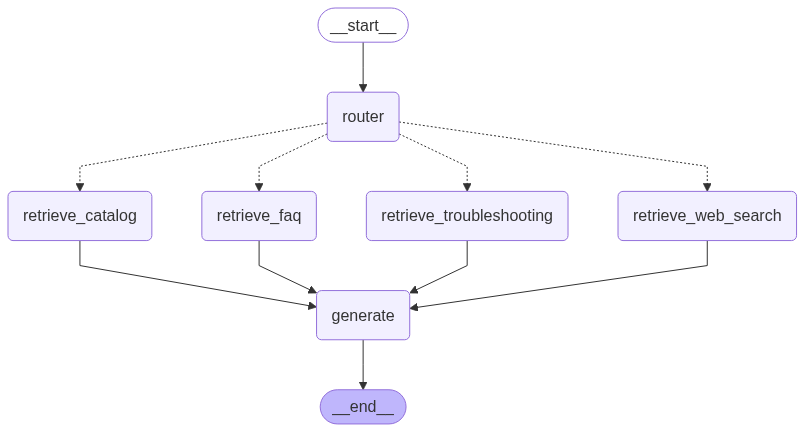

In [39]:
from IPython.display import Image, display

display(Image(router_rag_graph.get_graph().draw_mermaid_png()))

## Test the Complete Router RAG System

Let's test our router RAG system with various types of queries.

In [40]:
def ask_router_rag(query: str):
    """Ask a question to our Router RAG system."""
    print(f"\nQuery: {query}")
    print("=" * 70)
    
    # Run the router RAG workflow
    result = router_rag_graph.invoke({"query": query})
    
    print(f"\nAnswer: {result['answer']}")
    print("=" * 70)

In [41]:
# Test with a product recommendation query
ask_router_rag("I need a lightweight laptop for university. What do you recommend?")


Query: I need a lightweight laptop for university. What do you recommend?
Router Decision: catalog
Reasoning: The query is seeking a product recommendation for a lightweight laptop suitable for university, which falls under product information and recommendations in the catalog collection.
  Doc 1 [techmart_catalog.csv]: product_id: SKU254 | name: AeroLite 15 Slim Laptop | category: Laptop | price: 1249.0 | short_desc: ...
  Doc 2 [techmart_catalog.csv]: product_id: SKU028 | name: ZenLite 15 Evo Laptop | category: Laptop | price: 1199.0 | short_desc: Sl...
  Doc 3 [techmart_catalog.csv]: product_id: SKU050 | name: ZenithBook 15 Evo | category: Laptop | price: 1299.0 | short_desc: 15.6" ...
  Doc 4 [techmart_catalog.csv]: product_id: SKU164 | name: ZenithBook Air 13 | category: Laptop | price: 1199.0 | short_desc: Ultra-...
  Doc 5 [techmart_catalog.csv]: product_id: SKU306 | name: NeuraBook Air 13 | category: Laptop | price: 1199.0 | short_desc: Ultra-l...
Retrieved 5 documents from c

In [42]:
# Test with a shipping policy query
ask_router_rag("How long does shipping take?")


Query: How long does shipping take?
Router Decision: faq
Reasoning: The user is asking about shipping duration, which is related to shipping policies and delivery times covered in the FAQ collection.
  Doc 1 [techmart_faq.csv]: question: How long does standard shipping take within the continental US? | answer: Standard shippin...
  Doc 2 [techmart_faq.csv]: question: How much does international shipping cost? | answer: International shipping starts at USD ...
  Doc 3 [techmart_faq.csv]: question: Can I track my package after it ships? | answer: Absolutely. A tracking link is emailed to...
  Doc 4 [techmart_faq.csv]: question: Do you offer next‑day delivery for laptops? | answer: Yes, we offer overnight delivery on ...
  Doc 5 [techmart_faq.csv]: question: When will I receive my refund? | answer: Refunds are processed 3–5 business days after we ...
Retrieved 5 documents from FAQ
Generated answer using faq collection

Answer: Standard shipping within the continental US typically takes 3

In [43]:
# Test with a troubleshooting query
ask_router_rag("My laptop battery drains very quickly")


Query: My laptop battery drains very quickly
Router Decision: troubleshooting
Reasoning: The query involves diagnosing and resolving an issue with a laptop battery draining quickly, which is a common hardware-related problem likely covered in our troubleshooting guides.
  Doc 1 [techmart_troubleshooting.csv]: issue_title: UltraBook Pro battery drains quickly | product_id: SKU001 | symptoms: Battery indicator...
  Doc 2 [techmart_troubleshooting.csv]: issue_title: Zenith X5 battery drains overnight | product_id: SKU014 | symptoms: Battery drops 20 % ...
  Doc 3 [techmart_troubleshooting.csv]: issue_title: Laptop Battery Not Charging When Plugged In | product_id: SKU230 | symptoms: When the A...
  Doc 4 [techmart_troubleshooting.csv]: issue_title: Laptop Not Charging When Connected to USB-C Power Adapter | product_id: SKU177 | sympto...
  Doc 5 [techmart_troubleshooting.csv]: issue_title: PixelStream X5 5G Smartphone Battery Drains Rapidly | product_id: SKU171 | symptoms: Us...
Retrieve

## Test the Problematic Questions from Basic RAG

Now let's test the same problematic questions from the basic RAG notebook to see how router RAG handles them.

In [57]:
# troubleshooting vs product info
ask_router_rag("ultrabook pro charging ports")


Query: ultrabook pro charging ports
Router Decision: catalog
Reasoning: The query 'ultrabook pro charging ports' relates to product specifications and features of a particular laptop model, which is covered in the catalog collection.
  Doc 1 [techmart_catalog.csv]: product_id: SKU021 | name: ChargeHub 100 W GaN Charger | category: Power | price: 69.0 | short_desc:...
  Doc 2 [techmart_catalog.csv]: product_id: SKU001 | name: UltraBook Pro 14 Laptop | category: Laptop | price: 1499.0 | short_desc: ...
  Doc 3 [techmart_catalog.csv]: product_id: SKU232 | name: ZenithBook 11 Evo | category: Laptop | price: 1299.0 | short_desc: A slee...
  Doc 4 [techmart_catalog.csv]: product_id: SKU098 | name: PowerEdge Max 100W GaN Charger | category: Power | price: 89.99 | short_d...
  Doc 5 [techmart_catalog.csv]: product_id: SKU057 | name: ZenithBook 13 Evo | category: Laptop | price: 1299.0 | short_desc: Sleek ...
Retrieved 5 documents from catalog
Generated answer using catalog collection

Answer:

In [ ]:
# question about return policy for monitors / no longer returns info from catalog
ask_router_rag("What's your return policy for monitors?")


Query: What's your return policy for monitors?
Router Decision: faq
Reasoning: The query asks about the return policy, which is related to customer service and business policies covered in the faq collection.
  Doc 1 [techmart_faq.csv]: question: What is your return window? | answer: Most products can be returned in like‑new condition ...
  Doc 2 [techmart_faq.csv]: question: What if I receive a damaged product? | answer: Please email photos of the damage within 48...
  Doc 3 [techmart_faq.csv]: question: Do accessories come with warranty coverage? | answer: Accessories such as mice and keyboar...
  Doc 4 [techmart_faq.csv]: question: Is return shipping free? | answer: Return shipping is free for defective items; for change...
  Doc 5 [techmart_faq.csv]: question: How long is the warranty on laptops? | answer: All TechMart laptops carry a 1‑year limited...
Retrieved 5 documents from FAQ
Generated answer using faq collection

Answer: Most products at TechMart, including monitors, can b

In [51]:
# Test with web search queries that need current information
ask_router_rag("Windows 11 blue screen error 0x0000007E - how do I fix this?")


Query: Windows 11 blue screen error 0x0000007E - how do I fix this?
Router Decision: web_search
Reasoning: The query is about a specific Windows 11 blue screen error code that likely requires up-to-date, detailed troubleshooting information beyond the scope of the internal troubleshooting database.
  Doc 1 [https://www.salvagedata.com/blog/fix-windows-stop-error-0x0000007e]: Use a reliable registry cleaner to repair the 0x0000007e Blue Screen Error-related issues in the Win...
  Doc 2 [https://learn.microsoft.com/en-us/answers/questions/3968710/frequent-blue-screen-with-error-code-0x0000007e-(w?forum=windows-all&referrer=answers]: As part of troubleshooting, I removed the motherboard battery and flashed the BIOS. Unfortunately, t...
  Doc 3 [https://answers.microsoft.com/en-us/windows/forum/all/blue-screen-error-bugcheck-0x0000007e/b8c86686-246c-487a-aece-c74abf874168]: boot windows into safe mode only. Uninstall existing Nvidia drivers by using DDU software, and resta...
  Doc 4 [htt

In [52]:
# This query requires current hardware information not in our database
ask_router_rag("Whats the latest Nvidia GPU series for gaming?")


Query: Whats the latest Nvidia GPU series for gaming?
Router Decision: web_search
Reasoning: The user is asking about the latest Nvidia GPU series for gaming, which likely involves very recent product releases and up-to-date information not covered in our internal catalog. Therefore, web_search is the best option.
  Doc 1 [https://www.nvidia.com/en-us/geforce/]: DLSS 4 is a neural rendering breakthrough powered by GeForce RTX 50 Series GPUs that brings new Mult...
  Doc 2 [https://www.tomshardware.com/reviews/best-gpus,4380.html]: RTX 50-series GPUs are Nvidia's first with support for with multi-frame generation (MFG), which allo...
  Doc 3 [https://en.wikipedia.org/wiki/List_of_Nvidia_graphics_processing_units]: "New GeForce RTX 50 Series Graphics Cards & Laptops Powered By Nvidia Blackwell Bring Game-Changing ...
  Doc 4 [https://www.nvidia.com/en-us/geforce/graphics-cards/]: Explore NVIDIA GeForce graphics cards. RTX 50 Series, RTX 40 Series, and more....
  Doc 5 [https://www.ign.c

In [ ]:
# Try your own questions here!
your_question = ""
ask_router_rag(your_question)

## Comparison: Router RAG vs Basic RAG

Let's compare how Router RAG improves upon Basic RAG:

### Router RAG Advantages:

1. **Intent-Aware Routing**: Queries are automatically classified and routed to the most relevant collection
2. **Focused Context**: Only relevant documents are retrieved, eliminating noise from unrelated collections
3. **Domain Expertise**: Each collection can be optimized for its specific domain (products, support, policies)
4. **Better Precision**: Reduced false positives from semantically similar but contextually irrelevant documents
5. **Cleaner Answers**: Responses are more focused and less confused by mixed context types
6. **Integration with Multiple Data Sources / Web Search**: Current information retrieval for troubleshooting issues not in our database

### When Router RAG Excels:

- **Domain-Specific Questions**: "What laptops do you have?" → Direct to catalog
- **Policy Questions**: "How do returns work?" → Direct to FAQ
- **Technical Support**: "Screen flickering issue" → Direct to troubleshooting
- **Current Information**: "Windows 11 blue screen error" → Direct to web search

### Remaining Challenges:

- **Multi-Domain & Multi-Hop Queries**: Questions spanning multiple collections, or needing multple steps.
- **Router Accuracy**: Misclassification by the router can lead to searching the wrong collection
- **Noisy Documents within a Collection**: Even when querying a single index, the retriever can still return noisy / irrelevant documents.
